# Multi-scale Clustering Analysis of Wildfire Hazards and Machine Learning-based Burn Severity Prediction
## Visualization

## Required libraries and dependencies

In [1]:
import rasterio, os, glob, warnings, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.inspection import permutation_importance 

from sampling import *
from utils import *

warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

## Input Paths and Data
Change data paths to local

In [2]:
# Input image paths
basepath = '/Users/minho/Documents/GitHub/explainableFire/datasets'
# os.chdir(path)

# img_train = sorted(glob.glob('s2*.tif'))
# dem_train = sorted(glob.glob('dem*.tif'))
# slope_train = sorted(glob.glob('slope*.tif'))
# aoi_train = sorted(glob.glob('fire*.tif'))
# lulc_train = sorted(glob.glob('lulc*.tif'))

# Weather data
# rmin_train = sorted(glob.glob('rmin*.tif'))
# rmax_train = sorted(glob.glob('rmax*.tif'))
# tmmn_train = sorted(glob.glob('tmmn*.tif'))
# tmmx_train = sorted(glob.glob('tmmx*.tif'))
# vs_train = sorted(glob.glob('vs*.tif'))

In [3]:
# Input Parameters
number_of_sample_points = 10000 # This selects the number of samples from each burn severity class
random_state = 42 # Random seed number to keep consistent
input_bands = 5 # Number of features in the training dataset (10) and with weather (10 + 5)

patch_size = 10 # Patch size (Order of neighboring pixels - eg. 10 = 10x10 patch)

## Sampling
- Total samples: 10,000 samples (points at 10m resolution) with 2,500 samples for each burn severity class
- Split: Frequency relative to total pixel count for each burn severity class
- Method: Random sampling 

In [4]:
# Create input dataset stack
img_train, dem_train, slope_train, lulc_train, aoi_train = paths(basepath)

img_size_list = []

for i in range(len(img_train)):
    img, img_meta = open_multiband(img_train[i])    
    img_size_list.append(img.shape[0]*img.shape[1])    
    
del img_meta 

img_size_df = pd.DataFrame(columns = ['size', 'weight','weighted_pix', 'low','low-med','med-high','high'])
img_size_df.size = img_size_list
# img_size_df.reset_index(level=0, inplace=True)

# Random sampling for each image (based on AOI size and burn severity class frequency)
for i in range(len(img_size_df)):
    img_size_df['weight'][i] = img_size_df['size'][i]/img_size_df['size'].sum()
    img_size_df['weighted_pix'][i] = img_size_df['weight'][i]*100

    aoi, aoi_meta = open_data(aoi_train[i])
    aoi[aoi > 4] = 0 # Set nodata values to 0 or NaN
    
    img_size_df['low'][i] = len(aoi[aoi==1])
    img_size_df['low-med'][i] = len(aoi[aoi==2])
    img_size_df['med-high'][i] = len(aoi[aoi==3])
    img_size_df['high'][i] = len(aoi[aoi==4])
    
del aoi_meta

burn_sev_df = img_size_df.copy().drop(columns = ['size','weight','weighted_pix'])

for i in range(len(img_size_df)):
    burn_sev_df['low'][i] = img_size_df['low'][i]/img_size_df['low'].sum()*number_of_sample_points
    burn_sev_df['low-med'][i] = img_size_df['low-med'][i]/img_size_df['low-med'].sum()*number_of_sample_points
    burn_sev_df['med-high'][i] = img_size_df['med-high'][i]/img_size_df['med-high'].sum()*number_of_sample_points
    burn_sev_df['high'][i] = img_size_df['high'][i]/img_size_df['high'].sum()*number_of_sample_points

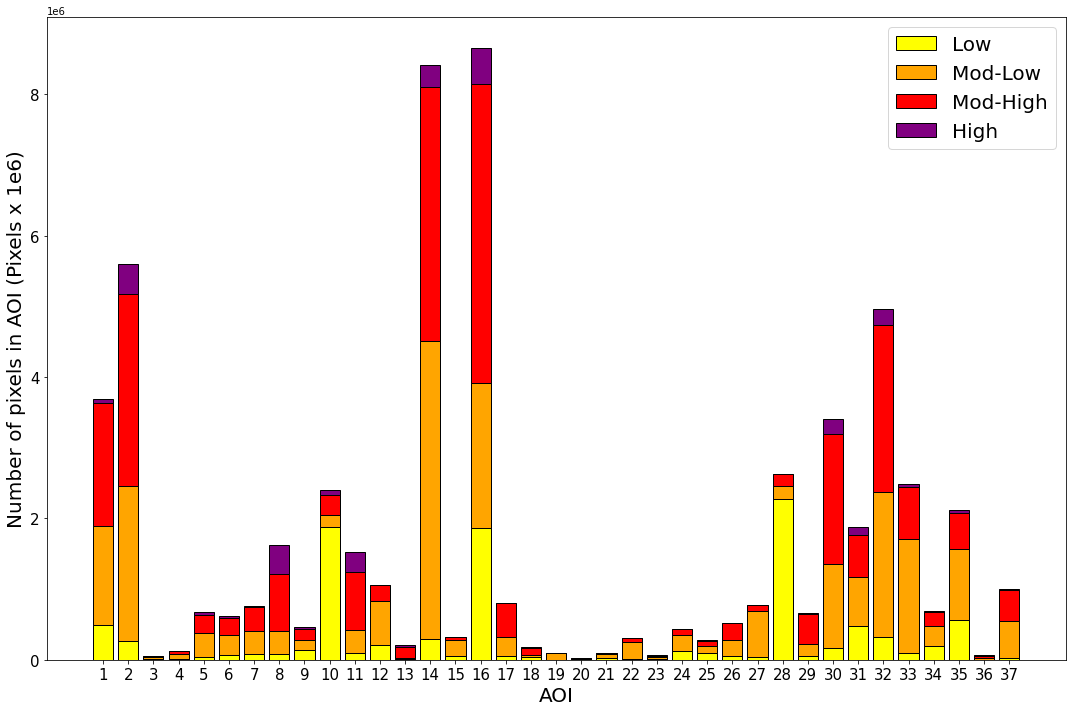

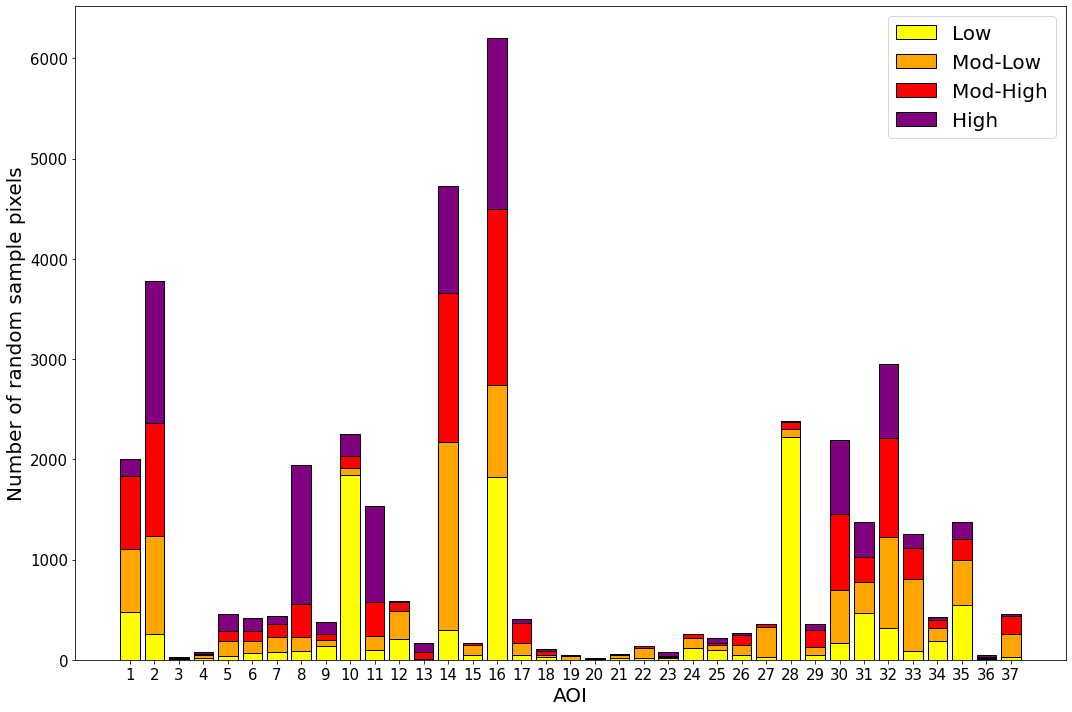

In [6]:
# All AOIs pixel distribution per burn severity
plt.figure(figsize=[15,10])

plt.bar(range(1,38), img_size_df.low, color='yellow', edgecolor='black')
plt.bar(range(1,38), img_size_df['low-med'], bottom=img_size_df.low, color='orange', edgecolor='black')
plt.bar(range(1,38), img_size_df['med-high'], bottom=img_size_df.low+img_size_df['low-med'], color='red', edgecolor='black')
plt.bar(range(1,38), img_size_df.high, bottom=img_size_df.low+img_size_df['low-med']+img_size_df['med-high'], color='purple', edgecolor='black')
plt.xlabel("AOI", size = 20)
plt.xticks(range(1,38), size=15)
plt.yticks(size=15)
plt.ylabel("Number of pixels in AOI (Pixels x 1e6)", size = 20)
plt.legend(["Low", "Mod-Low", "Mod-High", "High"], fontsize = 20)
plt.show()


# Random sampling distribution
# Set AOI sample counts
df1 = burn_sev_df.round(0).astype(int)

plt.figure(figsize=[15,10])

plt.bar(range(1,38), df1.low, color='yellow', edgecolor='black')
plt.bar(range(1,38), df1['low-med'], bottom=df1.low, color='orange', edgecolor='black')
plt.bar(range(1,38), df1['med-high'], bottom=df1.low+df1['low-med'], color='red', edgecolor='black')
plt.bar(range(1,38), df1.high, bottom=df1.low+df1['low-med']+df1['med-high'], color='purple', edgecolor='black')
plt.xlabel("AOI", size = 20)
plt.xticks(range(1,38), size=15)
plt.yticks(size=15)
plt.ylabel("Number of random sample pixels", size = 20)
plt.legend(["Low", "Mod-Low", "Mod-High", "High"], fontsize = 20)
plt.show()

## Data Visualization

In [ ]:
path = '/Users/minho/Desktop/CE263/Project/datasets/'

# Input image paths
os.chdir(path)

img_train = sorted(glob.glob('s2*.tif'))
dem_train = sorted(glob.glob('dem*.tif'))
slope_train = sorted(glob.glob('slope*.tif'))
aoi_train = sorted(glob.glob('fire*.tif'))
lulc_train = sorted(glob.glob('lulc*.tif'))

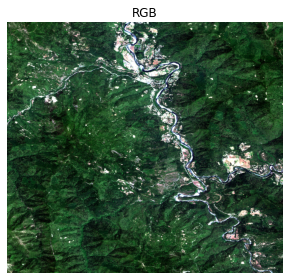

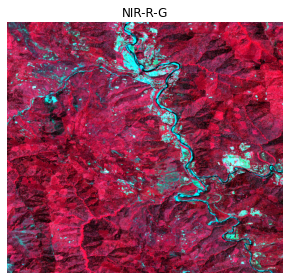

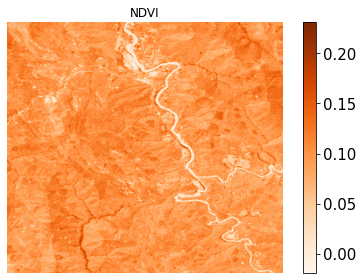

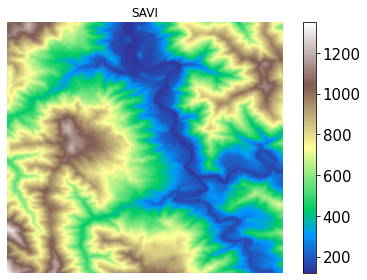

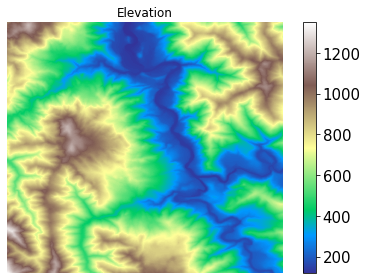

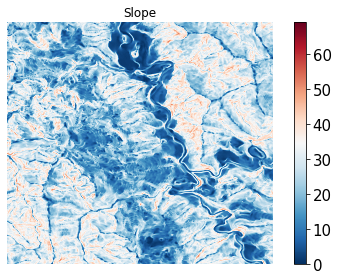

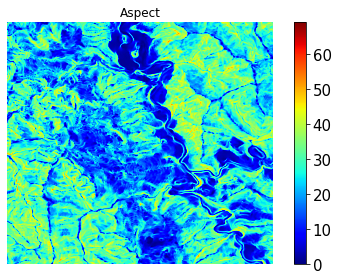

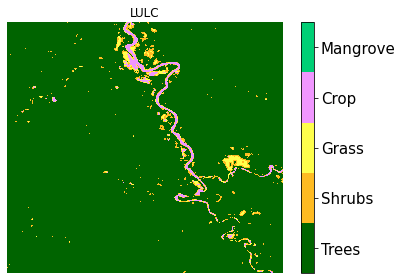

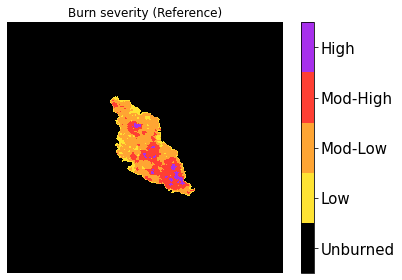

In [9]:
idx = 3

# RGB
img, _ = open_multiband(img_train[idx])
plt.imshow(clip(np.dstack((img[:,:,2], img[:,:,1], img[:,:,0])),2))
plt.title("RGB")
plt.axis('off')
plt.show()

# False composite
plt.imshow(clip(np.dstack((img[:,:,3], img[:,:,2], img[:,:,1])),2))
plt.title("NIR-R-G")
plt.axis('off')
plt.show()

# NDVI
plt.imshow(((img[:,:,3]/65535 - img[:,:,2]/65535) / (img[:,:,3]/65535 +img[:,:,2]/65535 +0.5))*(1+0.5), cmap='Oranges')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("NDVI")
plt.axis('off')
plt.show()

# SAVI
dem_img, _ = open_data(dem_train[idx])
plt.imshow(dem_img, cmap='terrain')
plt.axis('off')
plt.title("SAVI")
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.show()

# DEM Elevation
dem_img, _ = open_data(dem_train[idx])
plt.imshow(dem_img, cmap='terrain')
plt.axis('off')
plt.title("Elevation")
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.show()

# DEM Slope
slope_img, _ = open_data(slope_train[idx])
plt.imshow(slope_img, cmap='RdBu_r')
plt.axis('off')
plt.title("Slope")
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.show()

# DEM Aspect
aspect_img, _ = open_data(slope_train[idx])
plt.imshow(aspect_img, cmap='jet')
plt.axis('off')
plt.title("Aspect")
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.show()

# LULC
lulc_img, _ = open_data(lulc_train[idx])
cmap = matplotlib.colors.ListedColormap([
                                        '#006400',
                                        '#ffbb22',
                                        '#ffff4c',
                                        '#f096ff',
#                                         '#fa0000', #builtup
#                                         '#b4b4b4', #barren sparse veg
#                                         '#f0f0f0', #snow+ice
#                                         '#0064c8', #open water
#                                         '#0096a0', #herbaceous wetland
                                        '#00cf75',
#                                         '#fae6a0' # moss and lichen
                                        ])
boundaries = [10, 20, 30, 40, 95, 100]
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
plt.title("LULC")
im = plt.imshow(lulc_img, cmap=cmap, norm=norm)
plt.axis('off')
cbar = plt.colorbar(im)
# plt.colorbar().set_label(size=15)
cbar.set_ticks([15, 25, 35, 67.5, 97.5])
cbar.ax.tick_params(labelsize=15)
cbar.set_ticklabels(['Trees','Shrubs','Grass','Crop','Mangrove'])
plt.show()

aoi_img, _ = open_data(aoi_train[idx])
cmap = matplotlib.colors.ListedColormap(['#000000','#FFE333','#FFA533','#FF3F33','#A730EC'])
aoi_img[aoi_img > 4] = 0; aoi_img[aoi_img < 1] = 0;
im=plt.imshow(aoi_img, cmap=cmap, vmin=0, vmax=4)
plt.axis('off')
plt.title("Burn severity (Reference)")
cbar = plt.colorbar(im)
# plt.colorbar().set_label(size=15)
cbar.set_ticks([0.4, 1.2, 2, 2.8, 3.6])
cbar.ax.tick_params(labelsize=15)
cbar.set_ticklabels(['Unburned','Low','Mod-Low','Mod-High','High'])
plt.show()


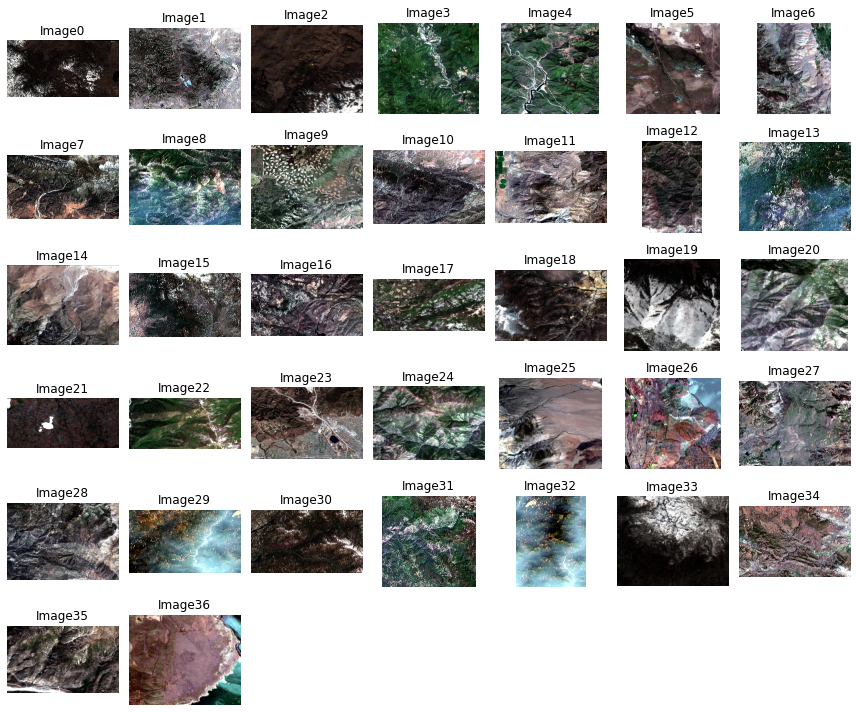

In [10]:
# RGB
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(img_train):
    img, _ = open_multiband(x)

    axs[num].imshow(clip(np.dstack((img[:,:,2], img[:,:,1], img[:,:,0])),2))
    axs[num].set_title(str('Image') + str(num))
    axs[num].axis('off')    


axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

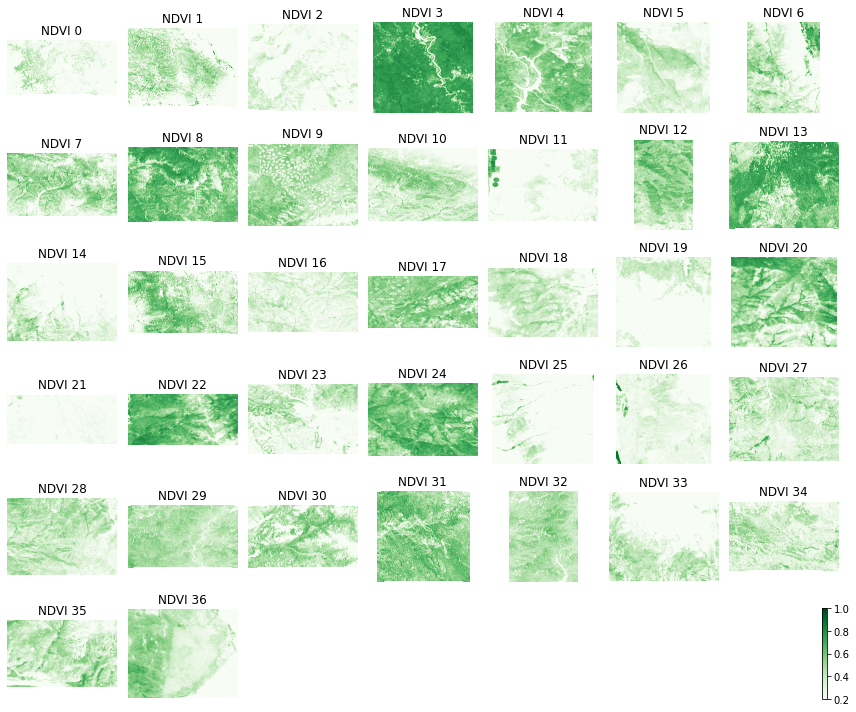

In [11]:
# NDVI
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(img_train):
    img, _ = open_multiband(x)

    im = axs[num].imshow((img[:,:,3]/65535 - img[:,:,2]/65535)/(img[:,:,3]/65535 + img[:,:,2]/65535), cmap='Greens', vmin=0.2,vmax=1)
    axs[num].set_title(str('NDVI ') + str(num))
    axs[num].axis('off')    
    
fig.colorbar(im)

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

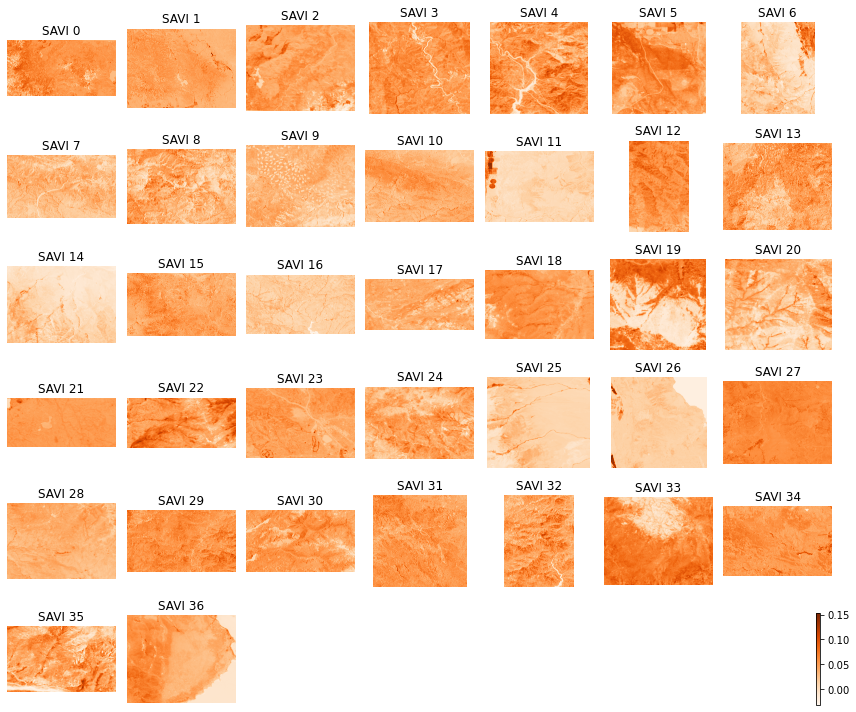

In [12]:
# SAVI
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(img_train):
    img, _ = open_multiband(x)

    im = axs[num].imshow(((img[:,:,3]/65535 - img[:,:,2]/65535) / (img[:,:,3]/65535 +img[:,:,2]/65535 +0.5))*(1+0.5), cmap='Oranges')
    axs[num].set_title(str('SAVI ') + str(num))
    axs[num].axis('off')    

fig.colorbar(im)

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

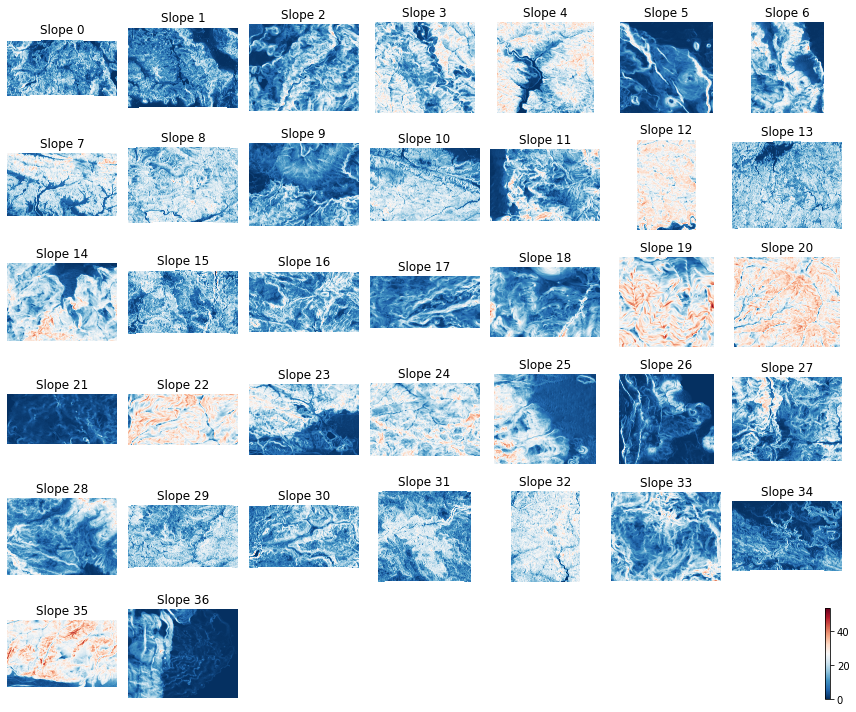

In [13]:
# Slope

fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(slope_train):
    img, _ = open_data(x)

    im = axs[num].imshow(img, cmap='RdBu_r')
    axs[num].set_title(str('Slope ') + str(num))
    axs[num].axis('off')    

fig.colorbar(im)

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

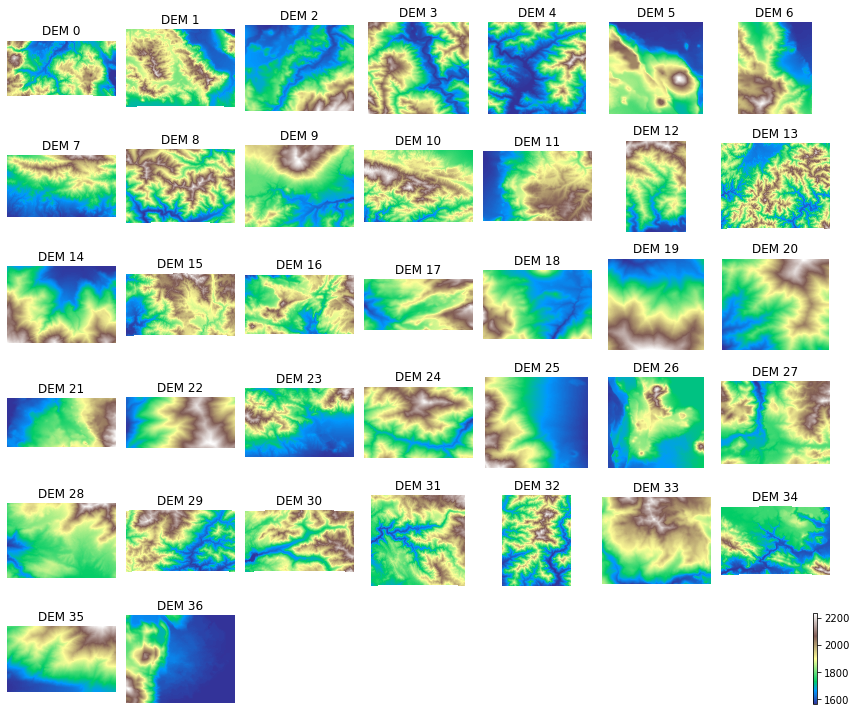

In [14]:
# Elevation
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(dem_train):
    img, _ = open_data(x)

    im = axs[num].imshow(img, cmap='terrain')
    axs[num].set_title(str('DEM ') + str(num))
    axs[num].axis('off')    

fig.colorbar(im)

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

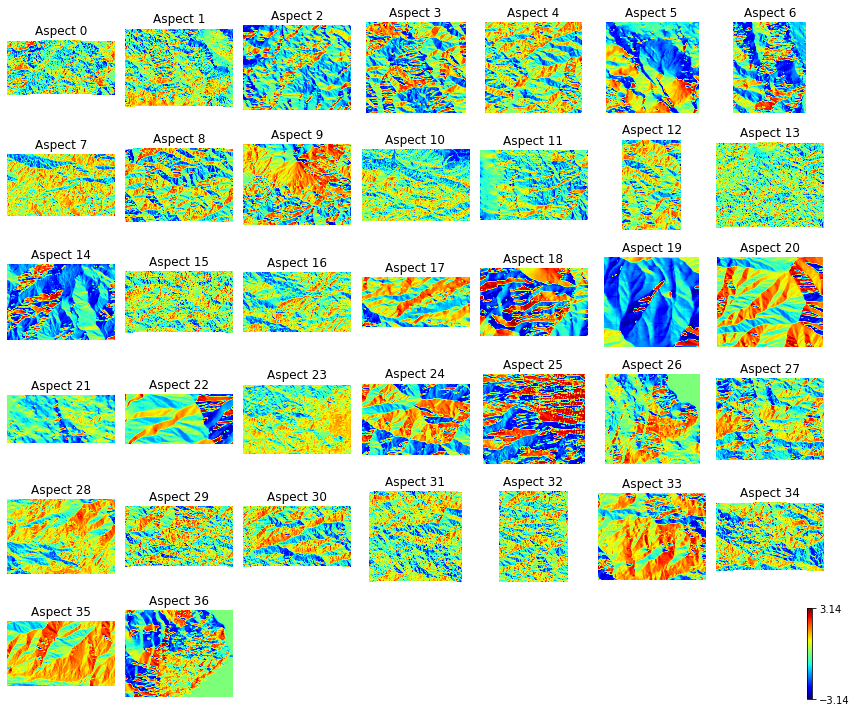

In [15]:
# Aspect
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(dem_train):
    img, _ = open_data(x)

    x, y = np.gradient(img)
    aspect = np.arctan2(-x, y)
    
    im = axs[num].imshow(aspect, cmap='jet')
    axs[num].set_title(str('Aspect ') + str(num))
    axs[num].axis('off')    

cbar = fig.colorbar(im, ticks=(-3.14,3.14))

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

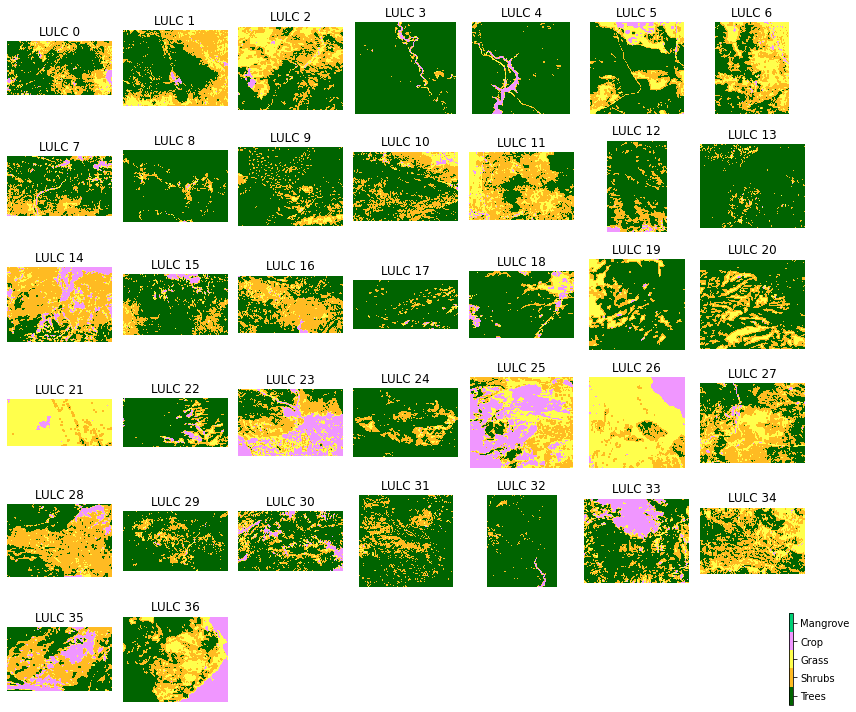

In [16]:
# LULC
cmap = matplotlib.colors.ListedColormap([
                                        '#006400',
                                        '#ffbb22',
                                        '#ffff4c',
                                        '#f096ff',
#                                         '#fa0000', #builtup
#                                         '#b4b4b4', #barren sparse veg
#                                         '#f0f0f0', #snow+ice
#                                         '#0064c8', #open water
#                                         '#0096a0', #herbaceous wetland
                                        '#00cf75',
#                                         '#fae6a0' # moss and lichen
                                        ])
boundaries = [10, 20, 30, 40, 95, 100]
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)


fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(lulc_train):
    img, _ = open_data(x)
#     img[[img != 10] or [img != 20] or [img != 30] or [img != 40] or [img != 95]]= 0
#     img[img > 1] = 0

    im = axs[num].imshow(img, cmap=cmap, norm=norm)
    
    axs[num].set_title(str('LULC ') + str(num))
    axs[num].axis('off')    

    
cbar = fig.colorbar(im)
cbar.set_ticks([15, 25, 35, 67.5, 97.5])
cbar.set_ticklabels(['Trees','Shrubs','Grass','Crop','Mangrove'])


axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

#     fig.colorbar.set_ticks([0,1,2,3,4])
#     cbar.set_ticklabels(['0','1','2','3','4'])

fig.tight_layout()

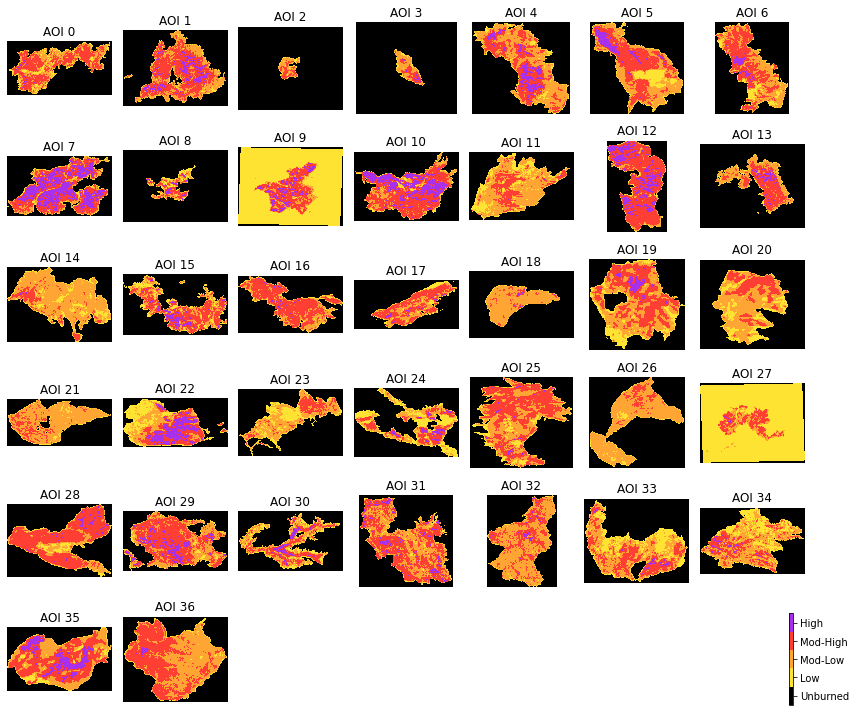

In [7]:
# Burn severity (Reference)
cmap = matplotlib.colors.ListedColormap(['#000000','#FFE333','#FFA533','#FF3F33','#A730EC'])

fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(aoi_train):
    img, _ = open_data(x)
    img[img > 4] = 0
    img[img < 1] = 0

    im = axs[num].imshow(img, cmap=cmap, vmin=0, vmax=4)
    axs[num].set_title(str('AOI ') + str(num))
#    aoi_train[num].split('fire')[1].split('_')[0])
    axs[num].axis('off')    

cbar = fig.colorbar(im)
cbar.set_ticks([0.4, 1.2, 2, 2.8, 3.6])
cbar.set_ticklabels(['Unburned','Low','Mod-Low','Mod-High','High'])

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

#     fig.colorbar.set_ticks([0,1,2,3,4])
#     cbar.set_ticklabels(['0','1','2','3','4'])

fig.tight_layout()